# EDA and baseline model

## Data overview
The dataset contains a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. There are 6 categories:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

## Goal
Create a model to predict the probabilities of each type toxicity.

## 2. Data pre-processing
### 2.1 Sample size

In [1]:
# load libraries
# basic
import numpy as np
import pandas as pd

# misc
import os
import sys
import gc
import time
import warnings

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
data_path='../data'

# check the files
os.listdir(data_path)

['test.csv', 'test_labels.csv', 'train.csv', 'sample_submission.csv']

In [3]:
# load the data
train_path = os.path.join(data_path, 'train.csv')
test_path = os.path.join(data_path, 'test.csv')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [4]:
train_row = train_df.shape[0]
test_row = test_df.shape[0]

print("Number of rows in train set : {}".format(train_row))
print("Number of rows in test set : {}".format(test_row))

Number of rows in train set : 159571
Number of rows in test set : 153164


### 2.2 Data analysis

#### 2.2.1 Glimpse
Each class are individually rated.

In [18]:
# take a look
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
119062,7c6dc99f84d60882,"""\n\n Your Edit to """"Talk:Cheyenne Frontier Da...",0,0,0,0,0,0
17663,2eae028e65f50c21,I have vandalized NOTHING \n\nWhat you have is...,0,0,0,0,0,0
32542,5694be507c9cedf2,2006 (UTC)\n\nI have moved two huge discussion...,0,0,0,0,0,0
149192,58b4abdb81556ea5,TG US S5 v S4 \n\nStop changing the season 4 e...,0,0,0,0,0,0
137465,df97c532f1627c2c,"""{| style=""""background-color:#F5FFFA; padding:...",0,0,0,0,0,0


**Example comments for each class**
- Some comments just repeat the same phrase or sentence over and over again
- There are some symbols (they don't make sense), url, IP address in the comment.
- They are shouting (upper-case words/sentences)

In [5]:
def show_comment(toxic_class, n):
    """
    Print out 'n' sample comments for a toxic class
    """
    ind=(train_df[toxic_class]==1)
    comment_class=train_df.loc[ind, "comment_text"]
    comments=comment_class.sample(n).values
    for i, comment in enumerate(comments):
        print("{} : {}".format(i, comment), 
              end="\n")
    return None

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for cls in class_names:
    print("Category : {}".format(cls))
    show_comment(cls, 2)
    print("-"*40)

Category : toxic
0 : Are you ok idiots... DSS monarchistic?! And they are not conservative, but ultra - nationalist, they supported Karadzic and they were burning embassies all around the Belgrade.
1 : Jehovah's Witnesses are a bunch of cultish FREAKS and they need to go ahead and drink the 'kool-aid' now and STOP KNOCKING ON MY FARKING DOOR and shove their hateful version of God up their arses!!!65.69.81.2
----------------------------------------
Category : severe_toxic
0 : fuck cocksucker titty marijuana nigger whore
1 : you suck dick and should be arrested and thrown in jail.  you also suck and should be blocked indefinitely. Just to let you guys know I am a sock puppet of The Cheapo. Take this into consideration and you will have yet anotehr account that is a sock puppet of the cheapo.
----------------------------------------
Category : obscene
0 : —   | Talk  I, who am coming in from the wild, I, who happen to be Reform and think this Sanhedrin is, pardon my French, bullshit, shal

#### 2.2.2 Missing values

There is no missing values in the file. That is great.

In [6]:
print("Check for missing values in Train set")
print(train_df.isnull().sum())

print("Check for missing values in Test set")
print(test_df.isnull().sum())

Check for missing values in Train set
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Check for missing values in Test set
id              0
comment_text    0
dtype: int64


#### 2.2.3 Imbalance classes

- Most comments are non-toxic (imbalance)
- Among those comments that are tagged, *toxic*, *obscene*, and *insult* are most frequent.
- The distribution across different cateogories are not important here because each cateogry was evaluated individually.

In [7]:
# number of toxic counts for each comment
toxic_counts = train_df.iloc[:, 2:].sum(axis=1)
train_df["non_toxic"] = (toxic_counts==0)

print("Number of total comments : {}".format(len(train_df)))
print("Number of non_toxic coments : {}".format(train_df["non_toxic"].sum()))

Number of total comments : 159571
Number of non_toxic coments : 143346


[]

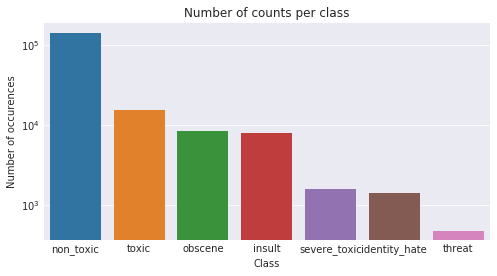

In [8]:
label_counts = train_df.iloc[:, 2:].sum().sort_values(ascending=False)

plt.figure(figsize=[8,4])
sns.barplot(label_counts.index, label_counts.values)
plt.title("Number of counts per class")
plt.xlabel("Class")
plt.ylabel("Number of occurences")
plt.semilogy()

## Modelling - Baseline
Simply extract word counts or tf-idf as features
- word counts
- tf-idf

Train with only 
- logistic regression

In [9]:
print(class_names)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [10]:
# combine text for preprocessing
train_text = train_df["comment_text"]
test_text = test_df["comment_text"]
all_text = pd.concat([train_text, test_text])

In [11]:
# set up two transformers
text_extraction = {
    'word_vect': CountVectorizer(encoding="unicode", 
                analyzer="word",
                token_pattern="\w{1,}",
                stop_words="english",
                ngram_range=(1,1),
                max_features=10000),
    'tfidf_vect': TfidfVectorizer(encoding="unicode", 
                analyzer="word",
                token_pattern="\w{1,}",
                stop_words="english",
                ngram_range=(1,1),
                max_features=10000)
}


for name, vectorizer in text_extraction.items():
    # transform comments into text features
    vectorizer.fit(all_text)
    train_features = vectorizer.transform(train_text)
    test_features = vectorizer.transform(test_text)

    # train the model for each class
    print('\n\n',
          'Transformer : {}'.format(name))
    scores=[]
    y_pred_word=pd.DataFrame.from_dict({id: test_df["id"]})
    for class_name in class_names:
        train_target = train_df[class_name]
        classifier = LogisticRegression(solver="sag")

        cv_score = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring="roc_auc"))
        scores.append(cv_score)
        print("Average CV score for {} : {}".format(class_name, cv_score))

        classifier.fit(train_features, train_target)
        y_pred_word[class_name]=classifier.predict_proba(test_features)[:, 1]
    print("Total average CV score for all classes : {}".format(np.mean(scores)))



 Transformer : word_vect
Average CV score for toxic : 0.7453902075124387
Average CV score for severe_toxic : 0.7732593998762459
Average CV score for obscene : 0.7523520478408922
Average CV score for threat : 0.6883750612305519
Average CV score for insult : 0.7326309101664625
Average CV score for identity_hate : 0.7005355641680676
Total average CV score for all classes : 0.7320905317991099


 Transformer : tfidf_vect
Average CV score for toxic : 0.9671216100363963
Average CV score for severe_toxic : 0.9850062011978881
Average CV score for obscene : 0.9836135197776358
Average CV score for threat : 0.9802786283887907
Average CV score for insult : 0.9742030129734341
Average CV score for identity_hate : 0.9724776879194135
Total average CV score for all classes : 0.9771167767155932


- The results from `TfidfVectorizer` is much better.

## More things to do

### More features
- Character n-grams
- Sentiment scores
- Word embeddings

Count features
- Character counts
- Word counts 
- Sentence counts
- Uppper-case words counts

### More model
- NB-SVM
- LSTM

### Hyperparameter tunning

**Calculate count features**

In [10]:
comment_words=train_df["comment_text"].str.split()

In [11]:
# count of words
train_df["n_words"]=comment_words.apply(lambda x: len(x))
# count of unique words
train_df["n_unique_words"]=comment_words.apply(lambda x: len(set(x)))
# count of upper words
train_df["n_upper_words"]=comment_words.apply(lambda x: len([w for w in x if w.isupper()]))
# count of letters
train_df["n_letters"]=train_df["comment_text"].apply(lambda x: len(x))